# Apply pixel classifier on all images in a folder,  create corresponding mask

In [24]:
from scipy import ndimage
from scipy import signal
from skimage.morphology import binary_erosion
import sys

from sklearn.ensemble import RandomForestClassifier
import glob
import os
import pickle as pkl
from skimage import io
from csbdeep.utils import normalize
import numpy as np
import skimage
from skimage.morphology import square
import scipy
from skimage.segmentation import expand_labels
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append(os.path.realpath('/Users/max/Desktop/Scripts_for_max/'))
from semantic_segmentation import init_VGG16_pyramid, fd_VGG16_pyramid
from magicgui import magicgui
import napari
import re


In [40]:
def spot_mask_from_labels(labels):
    '''takes label mask, shrinks objects and subtracts from original image.'''
    stim_width = 25
    footprint = np.ones((stim_width,stim_width))
    labels_b = labels>0
    labels_b_ero = binary_erosion(labels_b,footprint)
    labels_b_sub = np.logical_xor(labels_b,labels_b_ero)
    labels_b_sub = labels_b_sub.astype('uint8')
    labels_sub = np.multiply(labels_b_sub,labels)
    
    df = pd.DataFrame()
    props = skimage.measure.regionprops(labels)
    for prop in props[:]:
        df_spot = pd.DataFrame({'cell_label': [prop.label],'cell_x': [prop.centroid[0]], 'cell_y':[prop.centroid[1]], 'cell_area': [prop.area],'stim_width':[stim_width]})
        df = df.append(df_spot)

    return labels_b_sub,df

def frame_to_labels(frame):
    #f_h2b = frame[1,:,:].copy()
    f_h2b = frame[:,:].copy()
    f_h2b_scaled = normalize(f_h2b, 5,95)
    features = fd_VGG16_pyramid(f_h2b_scaled,models,shapes)
    to_predict = features.reshape(np.shape(features)[0]*np.shape(features)[1],np.shape(features)[2])
    prediction_list = clf.predict_proba(to_predict)[:,0]
    prediction_img = np.reshape(prediction_list, f_h2b_scaled.shape)
    #now run watershed on segmentaion, using no seed
    prediction_img = prediction_img>0.5
    prediction_img = skimage.morphology.erosion(prediction_img, square(5))
    prediction_img = skimage.morphology.remove_small_objects(prediction_img, min_size = 100**2)
    prediction_img = scipy.ndimage.morphology.binary_fill_holes(prediction_img)
        
    #labels = skimage.segmentation.watershed(-distance_img, mask = prediction_img)#, mask=prediction_img>0.5)
    labels = skimage.segmentation.watershed(~prediction_img, mask = prediction_img)

    return labels


### Import the classifier you want to use

In [263]:
file = open("/Users/max/Desktop/Scripts_for_max/classifier_max_2021-10-15_DLC1.pkl", "rb")
clf = pkl.load(file)
file.close()

In [251]:
file = open("/Users/max/Desktop/Scripts_for_max/classifier_max_2021-10-15_DLC1.pkl", "wb")
pkl.dump(clf, file)

file.close()

In [241]:
input_folder = '/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/'
output_folder_segmentation = '/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3'
#change experiment ID
Experiment_ID='FRET13_timelapse'
ch1_flatfield=io.imread('/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_13/flatfield/Averaged_FRET_flatfield.tif')
ch2_flatfield=io.imread('/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_13/flatfield/Averaged_CFP_flatfield.tif')
ch2='CFP'
ch1='FRET'

In [261]:
#CFP_corrected, masked_frame=flatfield_preprocessing(CFPframe, ch2_flatfield, frame_segmented)

def bg_calculation(masked_frame):
    #hist, bins = np.histogram(masked_frame, bins=50)
    #width = 0.7 * (bins[1] - bins[0])
    #center = (bins[:-1] + bins[1:]) / 2
#    plt.bar(center, hist, align='center', width = width)
#    plt.ylim(0,450000)
#    plt.xlim(0,750)
    #bg = np.percentile(bins[0:30], 75)
    bg = np.median(masked_frame)
    return bg

# Actual background substraction
def background_sub(image, bg):
    global bg_mask
    bg_z_image = image - bg
    bg_mask = np.zeros_like(bg_z_image)
    bg_mask[bg_z_image > 0] = 1
    bg_z_image = bg_mask*bg_z_image
    bg_z_image = bg_z_image.astype(np.float32) 
    return bg_z_image

def bg_correct(image, masked_frame):
    bg_calc = bg_calculation(masked_frame)
    corr_im = background_sub(image,bg_calc)
    return corr_im
def flatfield_preprocessing(img, flatfield, frame_segmented):
    #flatfield=signal.medfilt(flatfield, kernel_size=[11,11])
    flatfield=ndimage.median_filter(flatfield, size=8)
    imgcorrected=np.divide(img, flatfield)
    #grow the background mask
    frame_segmented=ndimage.morphology.binary_dilation(frame_segmented, iterations=30)
    masked_frame=imgcorrected.copy()
    masked_frame[frame_segmented>0]=0
    bg_corrected=bg_correct(imgcorrected, masked_frame)
    #plt.imshow(bg_corrected, cmap = 'gray')
    return bg_corrected, masked_frame
    #return imgcorrected, masked_frame
def image_ratioing(f, c, path, filename):
    '''
    needs as inputs the fret image, the CFP image, the path to the images, the filename of one of the images
    . needs to be called after flatfield correction
    '''
    #print(type(f))
    #print(type(c))    
    FRETratio=np.divide(f, c)
    #print('fretframe')
    #plt.imshow(f, cmap = 'gray')
    #plt.show()
    #print('CFPframe')
    #plt.imshow(c, cmap = 'gray')
    #plt.show()
    savestr=os.path.join(path, filename.split('.')[0]+'_ratio'+'.TIF')
    io.imsave(savestr, FRETratio, check_contrast=False)

    print('saving: ', savestr)
    return FRETratio

print('defined preprocessing functions' )



defined preprocessing functions


### Set input and output folders

### Search images

In [245]:
FRETfilenames = sorted(glob.glob(os.path.join(input_folder,'*FRET*.TIF')))
CFPfilenames = sorted(glob.glob(os.path.join(input_folder,'*CFP*.TIF')))
print(f'Found {len(FRETfilenames)} input files.')
print(f'Last file: {FRETfilenames[-2]}')
raw = io.imread(FRETfilenames[-1])

Found 106 input files.
Last file: /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/REF52_8_w26TIRFFRETacceptor.TIF


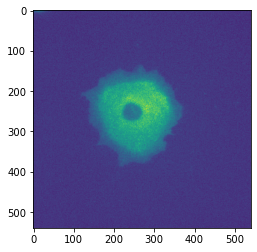

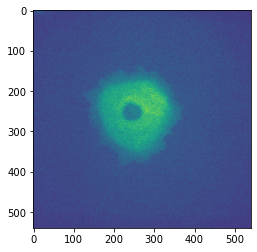

In [246]:
fov = 0
raw = io.imread(FRETfilenames[0])
frame = raw
norm_min = 5
norm_max = 95
f_h2b = frame[:,:].copy()
annotation_frame = normalize(f_h2b, norm_min,norm_max)
norm_min = 5
norm_max = 95
shapes = [(512,512),(64,64),(32,32)]
#shapes = [(540,540),(68,68),(32,32)]
models = init_VGG16_pyramid(shapes)
plt.imshow(frame)
plt.show()
plt.imshow(io.imread(CFPfilenames[0]))
plt.show()

In [262]:
#create the classifier
clf = RandomForestClassifier(random_state=0)

# create feature extractor and apply 
#shapes = [(1024,1024),(512,512),(256,256),(128,128),(64,64)]
shapes = [(512,512),(64,64),(32,32)]
models = init_VGG16_pyramid(shapes)
features = fd_VGG16_pyramid(annotation_frame,models,shapes)


@magicgui(call_button='train classifier')
def clf_widget():
    #run everytime the train button is pressed
    #extract the labels
    annotations = np.array(labels_layer.data)
    X,y = annotations_to_tensor(features,annotations)
    clf.fit(X, y) #train the classifier on the new labels
    #now predict the rest of the image with the new clf
    to_predict = features.reshape(np.shape(features)[0]*np.shape(features)[1],np.shape(features)[2])
    prediction_list = clf.predict_proba(to_predict)[:,0]
    prediction_img = np.reshape(prediction_list, annotation_frame.shape)
    
    #display the new prediciton
    prediction_layer.visible = True
    prediction_layer.data = prediction_img
    return clf

def annotations_to_tensor(feature_matrix,mask):
    #feature matrix dim: [x,y,nb_features]
    #possible mask elements: 0: not annotated, int[1,2]: class annotation
    y_labels=[] #where class labels are stored
    X_features=[] #where feature vectors are stored
    for x,y in np.argwhere(mask!=0):
        y_labels.append(mask[x,y])
        #X_features.append(feature_matrix[x,y,:])
        X_features.append(feature_matrix[x,y,])
    #turn list into np array
    X_features = np.asarray(X_features)
    return X_features,y_labels

viewer = napari.view_image(annotation_frame, name="My Image")


labels_layer = viewer.add_labels(np.zeros_like(annotation_frame).astype(int), seed = 0)
viewer.window.add_dock_widget(clf_widget)
prediction_layer = viewer.add_image(np.zeros_like(annotation_frame),colormap='PiYG')
prediction_layer.visible = False
prediction_layer.name = "Classifier prediction"
napari.run()

In [249]:
## Create the required folders 
def create_folders(path, directory):
    for i in directory:
        iDir=os.path.join(path, i)
        try:
            if not os.path.exists(iDir):
                os.makedirs(iDir)
                print('Created folder: ', iDir)
            else: 
                print('Folder: ', iDir, 'already exists')
        except OSError:
            print ('Error: Creating directory. ' + iDir)
required_folders = ['mask', 'stim_mask', 'ratio'] #leave this

create_folders(output_folder_segmentation,required_folders)  #leave this

Created folder:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/mask
Created folder:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/stim_mask
Created folder:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio


### Run the segmentation on all images

/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_10_w26TIRFFRETacceptor.TIF
frame_segmented


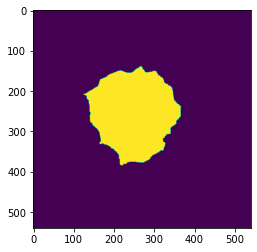

frame_mask


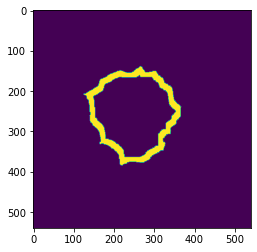

masked_frame


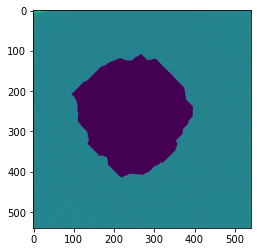

FRET_corrected


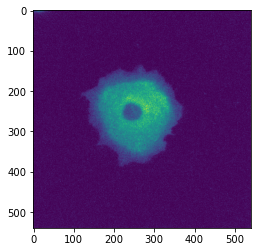

CFP_corrected


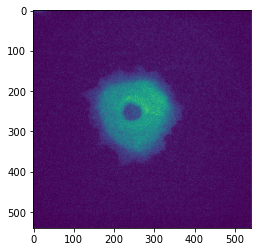

processing file  0  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_10_w26TIRFFRETacceptor_ratio.TIF
FRETratio


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


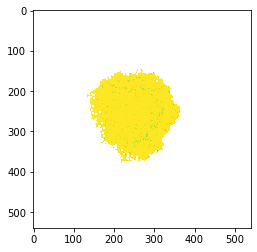

/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_11_w26TIRFFRETacceptor.TIF
processing file  1  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_11_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_12_w26TIRFFRETacceptor.TIF
processing file  2  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_12_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_13_w26TIRFFRETacceptor.TIF
processing file  3  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_13_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_14_w26TIRFFRETacceptor.TIF
processing file  4  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_14_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_15_w26TIRFFRETacceptor.TIF
processing file  5  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_15_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_16_w26TIRFFRETacceptor.TIF
processing file  6  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_16_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_17_w26TIRFFRETacceptor.TIF
processing file  7  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_17_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_18_w26TIRFFRETacceptor.TIF
processing file  8  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_18_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_19_w26TIRFFRETacceptor.TIF
processing file  9  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_19_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_1_w26TIRFFRETacceptor_s1_t1.TIF
processing file  10  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_1_w26TIRFFRETacceptor_s1_t1_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_20_w26TIRFFRETacceptor.TIF
processing file  11  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_20_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_21_w26TIRFFRETacceptor.TIF
processing file  12  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_21_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_22_w26TIRFFRETacceptor.TIF
processing file  13  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_22_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_23_w26TIRFFRETacceptor.TIF
processing file  14  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_23_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_24_w26TIRFFRETacceptor.TIF
processing file  15  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_24_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_25_w26TIRFFRETacceptor.TIF
processing file  16  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_25_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_26_w26TIRFFRETacceptor.TIF
processing file  17  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_26_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_27_w26TIRFFRETacceptor.TIF
processing file  18  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_27_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_28_w26TIRFFRETacceptor.TIF
processing file  19  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_28_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_29_w26TIRFFRETacceptor.TIF
processing file  20  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_29_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_2_w26TIRFFRETacceptor.TIF
processing file  21  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_2_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_30_w26TIRFFRETacceptor.TIF
processing file  22  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_30_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_31_w26TIRFFRETacceptor.TIF
processing file  23  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_31_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_32_w26TIRFFRETacceptor.TIF
processing file  24  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_32_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_33_w26TIRFFRETacceptor.TIF
processing file  25  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_33_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_34_w26TIRFFRETacceptor.TIF
processing file  26  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_34_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_35_w26TIRFFRETacceptor.TIF
processing file  27  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_35_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_36_w26TIRFFRETacceptor.TIF
processing file  28  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_36_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_37_w26TIRFFRETacceptor.TIF
processing file  29  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_37_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_38_w26TIRFFRETacceptor.TIF
processing file  30  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_38_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_39_w26TIRFFRETacceptor.TIF
processing file  31  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_39_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_3_w26TIRFFRETacceptor.TIF
processing file  32  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_3_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_40_w26TIRFFRETacceptor.TIF
processing file  33  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_40_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_41_w26TIRFFRETacceptor.TIF
processing file  34  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_41_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_42_w26TIRFFRETacceptor.TIF
processing file  35  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_42_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_43_w26TIRFFRETacceptor.TIF
processing file  36  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_43_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_44_w26TIRFFRETacceptor.TIF
processing file  37  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_44_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_45_w26TIRFFRETacceptor.TIF
processing file  38  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_45_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_46_w26TIRFFRETacceptor.TIF
processing file  39  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_46_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_47_w26TIRFFRETacceptor.TIF
processing file  40  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_47_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_48_w26TIRFFRETacceptor.TIF
processing file  41  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_48_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_49_w26TIRFFRETacceptor.TIF
processing file  42  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_49_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_4_w26TIRFFRETacceptor.TIF
processing file  43  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_4_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_50_w26TIRFFRETacceptor.TIF
processing file  44  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_50_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_51_w26TIRFFRETacceptor.TIF
processing file  45  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_51_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_52_w26TIRFFRETacceptor.TIF
processing file  46  of  106
saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_52_w26TIRFFRETacceptor_ratio.TIF


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_53_w26TIRFFRETacceptor.TIF
processing file  47  of  106


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


saving:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/ratio3/ratio/1B2_53_w26TIRFFRETacceptor_ratio.TIF
/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11/1B2_54_w26TIRFFRETacceptor.TIF


In [ ]:
timelapse=False
shapes = [(512,512),(64,64),(32,32)]
models = init_VGG16_pyramid(shapes)
frame_segmented = frame_to_labels(raw)

if timelapse == False:
   pattern = re.compile('(?P<Imagename>[^w]*).*(?P<Channel>FRET|CFP).*')
if timelapse == True:       
   pattern = re.compile('(?P<Imagename>[^w]*).*(?P<Channel>FRET|CFP).*(?P<Site>s[0-9]+)_t(?P<Timepoint>[0-9]+).*')
datatable=pd.DataFrame(columns=[ 'Experiment_ID','Filename', 'Cell_ID', 'Classifier',
                                'MeanIntensity_stimmaskRatio','MeanIntensity_cellmaskRatio', 
                                'MeanIntensity_CFP'])
for i, filename in enumerate(FRETfilenames):
    FRETframe = io.imread(filename)
    #get the pattern from the filename
    if timelapse == False:
        FRETname=re.search(pattern, filename.split('/')[-1]).group('Imagename')
    if timelapse == True:       
        FRETname=re.search(pattern, filename.split('/')[-1]).group('Imagename', 'Site', 'Timepoint')
    print(filename)
    #make segmentation
    # if input image has multiple channels, select the correct one here:
    #frame = frame[channel_nb,:,:] #where channel_nb is the channel you want to segment on
    frame_segmented = frame_to_labels(FRETframe)
    frame_mask, table = spot_mask_from_labels(frame_segmented)
   
    #show first segmentation

        
    #create a mask for background substraction based on segmentation    


    FRET_corrected, masked_frame=flatfield_preprocessing(FRETframe, ch1_flatfield, frame_segmented)
    io.imsave(os.path.join(output_folder_segmentation, 'ratio', os.path.basename(filename).split('.')[0] + 'FRET'+'.tiff'), FRET_corrected, check_contrast=False)

    #FRET_corrected= signal.medfilt(FRET_corrected, kernel_size=[3,3])
    
    if i == 0:
        print('frame_segmented')
        plt.imshow(frame_segmented)
        plt.show()
        print('frame_mask')
        plt.imshow(frame_mask)
        plt.show()
        print('masked_frame')
        plt.imshow(masked_frame)
        plt.show()
        print('FRET_corrected')
        plt.imshow(FRET_corrected)
        plt.show()
        #break
    FRET_masked=FRET_corrected.copy()
    FRET_masked[frame_segmented==0]=0
    io.imsave(os.path.join(output_folder_segmentation,'stim_mask', os.path.basename(filename).split('.')[0]+ 'stimmask' +'.tiff'), frame_mask, check_contrast=False)
    io.imsave(os.path.join(output_folder_segmentation, 'mask', os.path.basename(filename).split('.')[0] + 'mask'+'.tiff'), frame_segmented, check_contrast=False)
    for CFP in CFPfilenames:
        CFPframe=io.imread(CFP)
        if timelapse==False:
            CFPname=re.search(pattern, CFP.split('/')[-1]).group('Imagename')
        if timelapse == True:       
            CFPname=re.search(pattern, CFP.split('/')[-1]).group('Imagename','Site', 'Timepoint')
        
        if CFPname==FRETname:
            try:
                CFP_corrected, masked_frame=flatfield_preprocessing(CFPframe, ch2_flatfield, frame_segmented)
                #CFP_corrected=signal.medfilt(CFP_corrected, kernel_size=[3,3])
                io.imsave(os.path.join(output_folder_segmentation, 'ratio', os.path.basename(filename).split('.')[0] + 'CFP'+'.tiff'), CFP_corrected, check_contrast=False)

                if i==0:
                    print ('CFP_corrected')
                    plt.imshow(CFP_corrected)
                    plt.show()
                CFP_masked=CFP_corrected.copy()    
                CFP_masked[frame_segmented==0]=0
                print('processing file ', i, ' of ', len(FRETfilenames) )              
                FRETratio=image_ratioing(FRET_masked, CFP_masked, os.path.join(output_folder_segmentation, 'ratio'), filename.split('/')[-1])
                
                
                for f in np.unique(frame_segmented)[1:]:
                    if timelapse==False:
                        temp_data={'Experiment_ID': Experiment_ID, 'Filename':filename.split('/')[-1], 'Cell_ID':i, 
                                   'Classifier': filename.split('/')[-1].split('_')[0], 
                                   'MeanIntensity_stimmaskRatio': np.mean(np.ma.masked_invalid(FRETratio[(frame_mask>0) & (frame_segmented==f)])),
                                   'MeanIntensity_cellmaskRatio':np.mean(np.ma.masked_invalid(FRETratio[frame_segmented==f])),
                                   'MeanIntensity_CFP': np.mean(np.ma.masked_invalid(CFP_corrected[frame_segmented==f])),}
                    if timelapse==True:
                          temp_data={'Experiment_ID': Experiment_ID, 'Filename':''.join(re.search(pattern, filename.split('/')[-1]).group('Imagename', 'Site')),
                                     'Cell_ID':i, 
                                     'Timepoint': re.search(pattern, CFP.split('/')[-1]).group('Timepoint'),
                                     'Classifier': filename.split('/')[-1].split('_')[0], 
                                     'MeanIntensity_stimmaskRatio': np.mean(np.ma.masked_invalid(FRETratio[(frame_mask>0) & (frame_segmented==f)])),
                                     'MeanIntensity_cellmaskRatio':np.mean(np.ma.masked_invalid(FRETratio[frame_segmented==f])), 
                                     'MeanIntensity_CFP': np.mean(np.ma.masked_invalid(CFP_corrected[frame_segmented==f])),}
                  
                    datatable=datatable.append(temp_data, ignore_index=True)
                if i==0:
                    #print('FRETframe')
                    #plt.imshow(FRETframe)
                    #plt.show()
                    print('FRETratio')
                    
                    plt.imshow(FRETratio, cmap='viridis', vmax=1.4)
                    plt.show()
                    
                    
                #break
            except OSError as e:
                print (e) 
    datatable.to_csv(os.path.join(output_folder_segmentation, Experiment_ID+'.csv'))
    #break
datatable=datatable[datatable['MeanIntensity_cellmaskRatio']!='--']
datatable['MeanIntensity_cellmaskRatio']=datatable['MeanIntensity_cellmaskRatio'].astype(float)
datatable['MeanIntensity_stimmaskRatio']=datatable['MeanIntensity_stimmaskRatio'].astype(float)
datatable['MeanIntensity_CFP']=datatable['MeanIntensity_CFP'].astype(float)
datatable.to_csv(os.path.join(output_folder_segmentation, Experiment_ID+'.csv'))
#datatable.to_csv(os.path.join(output_folder_segmentation, Experiment_ID+'.csv'))
print('Finished processing all images!')

In [131]:
                    temp_data={'Experiment_ID': Experiment_ID, 'Filename':filename.split('/')[-1], 'Cell_ID':i, 'MeanIntensity_stimmaskRatio': np.mean(FRETratio([frame_mask>0]&[frame_segmented[i]])),
                    'MeanIntensity_cellmaskRatio':np.mean(FRETratio[frame_segmented[i]]), 'MeanIntensity_CFP':np.mean(CFP_corrected[frame_segmented[i]])}

In [89]:

print(np.mean(np.ma.masked_invalid(FRETratio[tuple([frame_mask>0] and [frame_segmented==i])])))
print(np.mean(np.ma.masked_invalid(FRETratio[frame_segmented==i])))


1.225992374572406
1.225992374572406


In [102]:
len(FRETratio[(frame_mask>0) & (frame_segmented==i)])

30661

In [108]:
FRETratio[frame_segmented==i])

0

In [103]:
filename.split('/')[-1].split('_')[0]

'flatfield'

In [116]:
np.mean(np.ma.masked_invalid(FRETratio[(frame_mask>0) & (frame_segmented==f)]))

1.3073466566957381

In [111]:
print(i)

63


In [117]:
np.mean(np.ma.masked_invalid(FRETratio[frame_segmented==i]))

1.376080839120827